# Modèle de réseau neuronale

C'est plus simple de faire le modèle sur le notebook pour pouvoir analyser chaque étape avec précision

In [ ]:
#Imports

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import seaborn as sns #On ne sait jamais que ça serve
import pandas as pd #Même argument


In [3]:
#from alexnet_pytorch import AlexNet # ça fait planter matplotlib
#A_model = AlexNet.from_pretrained('alexnet', num_classes=10)

In [4]:
#Insert des données

In [5]:
#Idéalement, il faudrait ajouter les données batch par batch pour ne pas trop faire souffrir la ram

In [6]:
labels_csv = pd.read_csv('DATA\\labels.csv')

In [7]:
for line in labels_csv.values:
    label = line[0]
    name = line[1]
    #print(f"Le label est '{label}' et le nom de la vidéo : '{name}'")

In [8]:
X_link = []
y = []
for label,name in labels_csv.values:
    X_link.append(name)
    y.append(label)

In [9]:
#a_vid.get(cv2.CAP_PROP_POS_MSEC) #donne la position dans la vidéo en ms, on est à 25 fps donc chaque image est espacée de 40ms


### function: insert imgs/videos

In [10]:
def get_imgs_from_path(path,fps = -1):
    '''
    Retourne une liste d'images. La liste d'image a le nombre de fps voulu
    '''
    cap = cv2.VideoCapture(path)
    fps_actu = cap.get(cv2.CAP_PROP_FPS)
    if fps <= -1: fps = fps_actu #Je peux ne pas donner de fps et ça va prendre le nombre d'fps initial
    ecart_voulu = int(1000/fps)
    ecart_initial = int(1000/fps_actu)
    imgs = []
    
    
    while(cap.isOpened()):
        ret, frame = cap.read()

        if ret: #Sinon ça plante quand il n'y a plus d'images
            
            #Bonne couleur
            frame_RGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            
            #Récupère seulement certaines images
            t_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
            modulo = t_ms % ecart_voulu
            if modulo < ecart_initial:
                #Isoler les images
                imgs.append(frame_RGB)
            
        else: #Va jusqu'au bout de la vidéo
            break
    else:
        print("Le fichier n'a pas pu être ouvert")
    cap.release()
    
    return imgs

In [11]:
def get_mov_imgs_from_path(path,fps = -1):
    '''
    Retourne une liste d'images. La liste d'image a le nombre de fps voulu
    reprend que le mouvement
    '''
    cap = cv2.VideoCapture(path)
    fps_actu = cap.get(cv2.CAP_PROP_FPS)
    print(f"Fps de ma video n° {path}: {fps_actu}")
    if fps <= -1: fps = fps_actu #Je peux ne pas donner de fps et ça va prendre le nombre d'fps initial
    ecart_voulu = int(1000/fps)
    ecart_initial = int(1000/fps_actu)
    imgs = []
    
    ret, frame = cap.read()
    
    while(cap.isOpened()):
        prev = frame
        ret, frame = cap.read()

        if ret: #Sinon ça plante quand il n'y a plus d'images
            #Récupère seulement certaines images
            t_ms = cap.get(cv2.CAP_PROP_POS_MSEC)
            modulo = t_ms % ecart_voulu
            if modulo < ecart_initial:
                #Isoler les images
                
                diff = cv2.absdiff(frame,prev)  
                
                diff_gray = cv2.cvtColor(diff,cv2.COLOR_BGR2GRAY)
                
                #Normalisation foireuse pour avoir une belle image
                max_ = np.max(diff_gray)
                ratio = 255.0 / max_
                diff_gray = diff_gray * ratio
                
                
                #_,diff_thresh = cv2.threshold(diff_gray,15,255,cv2.THRESH_BINARY)
                #diff_thresh, c'est juste le mouvement Ici on isole l'image en couleur
                #frame_rgb = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
                #J'isole le mouvement de l'image initiale pour avoir une sortie en couleur
                #mov = cv2.bitwise_and(frame_rgb,frame_rgb,mask = diff_thresh)
                
                #On va travailler avec des images en nuance de gris, c'est bcp plus simple
                imgs.append(diff_gray)
            
        else: #Va jusqu'au bout de la vidéo
            break
    else:
        print("Le fichier n'a pas pu être ouvert")
    cap.release()
    
    return imgs

In [13]:
mov_imgs = get_mov_imgs_from_path('DATA\\Videos\\video_65.avi',10)
#mov_imgs = resize_imgs(mov_imgs,(160,120))

Fps de ma video n° DATA\Videos\video_65.avi: 25.0


(480, 640)


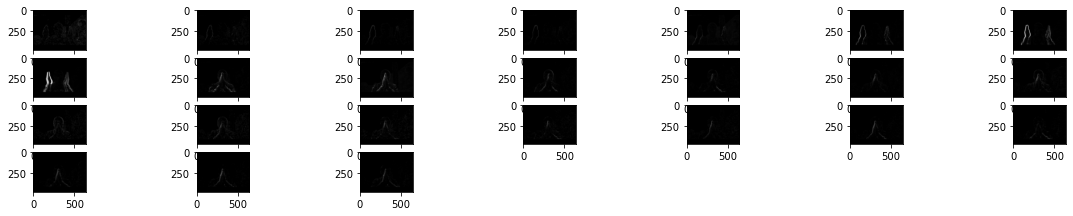

In [14]:
plt.figure(figsize=(20,60)) #(20,60) pour des images en (120,160). (20,180) pour des images en (480,640)
print(mov_imgs[1].shape)
columns = 7
for i, img in enumerate(mov_imgs):
    plt.subplot(int(len(img) / columns + 1), columns, i + 1)
    plt.imshow(img,"gray")

### function: resize

In [15]:
def resize_imgs(imgs,nsize):
    '''
    Change la taille de l'image.
    Le premier élément de nsize est la longueur (width), le deuxième la hauteur (height)
    '''
   # new_imgs = []
  #  for img in imgs:
 #       new_imgs.append(cv2.resize(img, dsize=nsize, interpolation=cv2.INTER_CUBIC))
#    return new_imgs
    return [cv2.resize(img, dsize=nsize, interpolation=cv2.INTER_CUBIC) for img in imgs]

In [16]:
#plt.imshow(imgs[2])

In [17]:
def reduce_fps(imgs,ratio = 6):
    '''
    imgs est une liste d'images
    1/ratio est le nombre d'images qu'on garde
    '''
    new_imgs = []
    for i,img in enumerate(imgs):
        if i % ratio == 0:
            new_imgs.append(img)
    return new_imgs    

## Real Insert

In [18]:
#Récupère toutes les vidéos, prend slmt z fps et les resize
import time
folder_path = 'Data\\Videos\\'
fps = -1
size = (320,240) # La shape initial est (480, 640, 3), Il faut inverser le sens de with et height.
#Size demi par rapport à initial

start = time.time()
X = []
for name in X_link:
    file_path = folder_path + name
    imgs_of_video = get_mov_imgs_from_path(file_path,fps)
    resized_imgs = resize_imgs(imgs_of_video, size)
    X.append(resized_imgs)
end = time.time()
print(f"ça a prit {end-start} secondes")

Fps de ma video n° Data\Videos\video_0.avi: 25.0
Fps de ma video n° Data\Videos\video_1.avi: 25.0
Fps de ma video n° Data\Videos\video_2.avi: 25.0
Fps de ma video n° Data\Videos\video_3.avi: 25.0
Fps de ma video n° Data\Videos\video_4.avi: 25.0
Fps de ma video n° Data\Videos\video_5.avi: 25.0
Fps de ma video n° Data\Videos\video_6.avi: 25.0
Fps de ma video n° Data\Videos\video_7.avi: 25.0
Fps de ma video n° Data\Videos\video_8.avi: 25.0
Fps de ma video n° Data\Videos\video_9.avi: 25.0
Fps de ma video n° Data\Videos\video_10.avi: 25.0
Fps de ma video n° Data\Videos\video_11.avi: 25.0
Fps de ma video n° Data\Videos\video_12.avi: 25.0
Fps de ma video n° Data\Videos\video_13.avi: 25.0
Fps de ma video n° Data\Videos\video_14.avi: 25.0
Fps de ma video n° Data\Videos\video_15.avi: 25.0
Fps de ma video n° Data\Videos\video_16.avi: 25.0
Fps de ma video n° Data\Videos\video_17.avi: 25.0
Fps de ma video n° Data\Videos\video_18.avi: 25.0
Fps de ma video n° Data\Videos\video_19.avi: 25.0
Fps de ma 

In [19]:
print(f"Il y a {len(X)} vidéos et {len(y)} labels") #Petite vérification
print(X[0][0].shape)

Il y a 99 vidéos et 99 labels
(240, 320)


In [22]:
[f"{len(vid)} , {e}" for e,vid in enumerate(X)] # Toutes les vidéos n'ont pas le même nombre de frame


['58 , 0',
 '59 , 1',
 '59 , 2',
 '59 , 3',
 '52 , 4',
 '38 , 5',
 '49 , 6',
 '43 , 7',
 '43 , 8',
 '51 , 9',
 '50 , 10',
 '53 , 11',
 '59 , 12',
 '61 , 13',
 '56 , 14',
 '50 , 15',
 '44 , 16',
 '52 , 17',
 '52 , 18',
 '53 , 19',
 '59 , 20',
 '59 , 21',
 '59 , 22',
 '59 , 23',
 '60 , 24',
 '59 , 25',
 '59 , 26',
 '59 , 27',
 '59 , 28',
 '59 , 29',
 '59 , 30',
 '59 , 31',
 '60 , 32',
 '59 , 33',
 '60 , 34',
 '59 , 35',
 '59 , 36',
 '59 , 37',
 '59 , 38',
 '59 , 39',
 '59 , 40',
 '60 , 41',
 '59 , 42',
 '59 , 43',
 '59 , 44',
 '59 , 45',
 '59 , 46',
 '60 , 47',
 '59 , 48',
 '59 , 49',
 '60 , 50',
 '59 , 51',
 '59 , 52',
 '59 , 53',
 '58 , 54',
 '59 , 55',
 '60 , 56',
 '59 , 57',
 '59 , 58',
 '60 , 59',
 '59 , 60',
 '59 , 61',
 '60 , 62',
 '60 , 63',
 '60 , 64',
 '60 , 65',
 '59 , 66',
 '60 , 67',
 '59 , 68',
 '59 , 69',
 '58 , 70',
 '59 , 71',
 '60 , 72',
 '59 , 73',
 '59 , 74',
 '59 , 75',
 '59 , 76',
 '60 , 77',
 '60 , 78',
 '61 , 79',
 '60 , 80',
 '59 , 81',
 '59 , 82',
 '59 , 83',
 '

(240, 320)


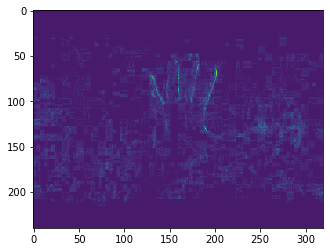

In [21]:
plt.imshow(X[0][3])
print(X[0][3].shape)

C'est ok pour l'import des vidéos et le traitement de celles-ci
On prend un certain nombre de FPS, leur taille est réduite et elles sont mises dans une grande liste 
dont l'index correspond à l'index du label dans y

## Modele fabrication

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Model Training

## Modele test 

